In [2]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import load_img
import numpy as np
import os
from google.colab import drive
import pandas as pd 
import cv2
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/dataset
%matplotlib inline


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/dataset


In [4]:
train_dir = "CamVid/train/"
train_label_dir = "CamVid/train_labels/"
val_dir = "CamVid/val/"
val_label_dir = "CamVid/val_labels/"
batch_sz = 4
epochs = 10


In [5]:
df = pd.read_csv('class_dict.csv',index_col=0)
colors = {cl:list(df.loc[cl, :]) for cl in df.index}

idx2rgb={idx:np.array(rgb) for idx, (cl, rgb) in enumerate(colors.items())}


In [6]:
def adjust_mask(mask):
    
    semantic_map = []
    #mask = mask.T
    for colour in list(colors.values()):  
        equality = mask == colour# 256x256x3 with True or False
        class_map = np.all(equality, axis = -1)# 256x256 If all True, then True, else False
        semantic_map.append(class_map)# List of 256x256 arrays, map of True for a given found color at the pixel, and False otherwise.
    semantic_map = np.stack(semantic_map, axis=-1)# 256x256x32 True only at the found color, and all False otherwise.

    return np.float32(semantic_map)# convert True/False to numbers
  
  
def map_to_rgb(p):

    return idx2rgb[p[0]]

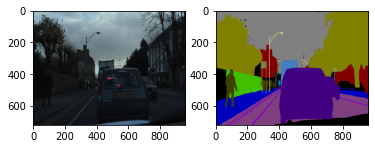

In [7]:
img = cv2.imread(train_dir + '/0001TP_009210.png') # cv2 load img as BGR 
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
label = cv2.imread(train_label_dir +'/0001TP_009210_L.png')
label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(label)

In [8]:
def load_dataset(dir,labels_dir):

  img_name = sorted(os.listdir(dir))
  label_name = sorted(os.listdir(labels_dir))
  x = np.array([np.array(load_img(dir + file, target_size=(256,256)))*1./255 for file in img_name])
  y = np.array([adjust_mask(np.array(load_img(labels_dir + file, target_size=(256,256)))) for file in label_name])

  return x,y

train_x,train_y = load_dataset(train_dir,train_label_dir)
val_x,val_y = load_dataset(val_dir,val_label_dir)

print(train_x.shape,train_y.shape)
print(val_x.shape,val_y.shape)

(369, 256, 256, 3) (369, 256, 256, 32)
(100, 256, 256, 3) (100, 256, 256, 32)


In [ ]:
img = train_x[100]
mask = train_y[100]
rgb_mask = np.apply_along_axis(map_to_rgb, -1, np.expand_dims(np.argmax(mask, axis=-1), -1))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(rgb_mask)

In [10]:
def UNET(input_size = (256,256,3), n_class = 32,pretrained = 'unet_pretrained.hdf5'):
  input = Input(input_size)
  # downsampling layer (encoder par) 
  down_11 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input)
  down_12 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_11)
  pool1 = MaxPooling2D(pool_size=(2, 2))(down_12)

  down_21 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  down_22 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_21)
  pool2 = MaxPooling2D(pool_size=(2, 2))(down_22)

  down_31 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  down_32 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_31)
  pool3 = MaxPooling2D(pool_size=(2, 2))(down_32)

  down_41 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  down_42 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_41)
  drop4 = Dropout(0.5)(down_42)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  down_51 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  down_52 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(down_51)
  drop5 = Dropout(0.5)(down_52)

  # decoder part of Unet architecture
  up_1 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge = concatenate([drop4,up_1], axis = 3)
  conv_11 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
  conv_12 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_11)

  up_2 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_12))
  merge = concatenate([down_32,up_2], axis = 3)
  conv_21 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
  conv_22 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_21)

  up_3 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_22))
  merge = concatenate([down_22,up_3], axis = 3)
  conv_31 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
  conv_32 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_31)

  up_4 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_32))
  merge = concatenate([down_12,up_4], axis = 3)
  conv_41 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
  conv_42 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_41)



  out = Conv2D(n_class, (1,1), padding='same')(conv_42)
  print(out.shape)
  output_layer = Activation('softmax')(out)
  model = Model(input,output_layer)

  #if pretrained:
   # model.load_weights(pretrained)

  return model

In [13]:
model = UNET(n_class= 32)
model.summary()

(None, 256, 256, 32)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_________________________________________________________________________

In [15]:
model_checkpoint = ModelCheckpoint('unet_camvid.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit(x=train_x, 
              y=train_y,
              validation_data=(val_x, val_y),
              batch_size=batch_sz,# 32 gives OOM sometimes
              epochs=epochs,
              callbacks=[model_checkpoint])

Epoch 1/10
93/93 [==============================] - 73s 359ms/step - loss: 2.5576 - accuracy: 0.3269 - val_loss: 1.4612 - val_accuracy: 0.6218

Epoch 00001: val_loss improved from inf to 1.46124, saving model to unet_camvid.hdf5
Epoch 2/10
93/93 [==============================] - 30s 327ms/step - loss: 1.3482 - accuracy: 0.6283 - val_loss: 1.3424 - val_accuracy: 0.6561

Epoch 00002: val_loss improved from 1.46124 to 1.34244, saving model to unet_camvid.hdf5
Epoch 3/10
93/93 [==============================] - 31s 337ms/step - loss: 1.1603 - accuracy: 0.6738 - val_loss: 1.4291 - val_accuracy: 0.6032

Epoch 00003: val_loss did not improve from 1.34244
Epoch 4/10
93/93 [==============================] - 32s 348ms/step - loss: 1.0481 - accuracy: 0.7107 - val_loss: 1.0854 - val_accuracy: 0.7074

Epoch 00004: val_loss improved from 1.34244 to 1.08538, saving model to unet_camvid.hdf5
Epoch 5/10
93/93 [==============================] - 33s 352ms/step - loss: 0.8498 - accuracy: 0.7746 - val_los

In [32]:
img = train_x[0]
g_label = train_y[0]
g_label = np.apply_along_axis(map_to_rgb, -1, np.expand_dims(np.argmax(g_label, axis=-1), -1))
output = model.predict(np.expand_dims(img, 0))
predict_mask = np.argmax(output, axis=-1)
predict_mask = np.apply_along_axis(map_to_rgb, -1, np.expand_dims(predict_mask, -1))

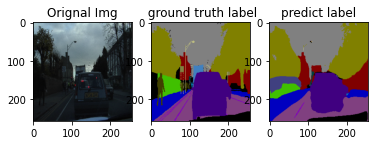

In [34]:
plt.subplot(1,3,1)
plt.title('Orignal Img')
plt.imshow(img)
plt.subplot(1,3,2)
plt.title(' ground truth label')
plt.imshow(g_label)
plt.subplot(1,3,3)
plt.title('predict label')
plt.imshow(predict_mask[0])
